## 0. Import libraries

In [208]:
import os 
os.chdir('../..')

import numpy as np
import pandas as pd
import seaborn as sns
import tellurium as te
import re
import textwrap
import matplotlib.pyplot as plt
import itertools
import pickle

from mpl_toolkits.axes_grid1 import make_axes_locatable

from roadrunner import Config, Logger
Logger.disableLogging()
Config.setValue(Config.ROADRUNNER_DISABLE_PYTHON_DYNAMIC_PROPERTIES, True)
Config.setValue(Config.LOADSBMLOPTIONS_RECOMPILE, False) 
Config.setValue(Config.LLJIT_OPTIMIZATION_LEVEL, 4)
Config.setValue(Config.LLVM_SYMBOL_CACHE, True)
Config.setValue(Config.LOADSBMLOPTIONS_OPTIMIZE_GVN, True)
Config.setValue(Config.LOADSBMLOPTIONS_OPTIMIZE_CFG_SIMPLIFICATION, True)
Config.setValue(Config.LOADSBMLOPTIONS_OPTIMIZE_INSTRUCTION_COMBINING, True)
Config.setValue(Config.LOADSBMLOPTIONS_OPTIMIZE_DEAD_INST_ELIMINATION, True)
Config.setValue(Config.LOADSBMLOPTIONS_OPTIMIZE_DEAD_CODE_ELIMINATION, True)
Config.setValue(Config.LOADSBMLOPTIONS_OPTIMIZE_INSTRUCTION_SIMPLIFIER, True)
Config.setValue(Config.SIMULATEOPTIONS_COPY_RESULT, True)

In [209]:
rfit = te.loads('/workspaces/ECFERS/notebooks/endogenous_analysis/250409_M3_B.sbml')
# rfit.integrator.absolute_tolerance = 1e-8
# rfit.integrator.relative_tolerance = 1e-8
# rfit.integrator.maximum_num_steps = 2000
model_rxns = pd.read_csv('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/Reactions_M3_B.csv')
sbm = pd.read_csv('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/SpeciesBaseMechanism_biosyn.csv')

In [4]:
kegg_labels = pd.read_csv('/workspaces/ECFERS/kegg_labels.csv',dtype='str',encoding='us-ascii',encoding_errors='ignore')
kegg_labels = kegg_labels.where(kegg_labels.notnull(), None)
translator_dict = pd.Series(kegg_labels['Label'].values, index=kegg_labels['KEGG ID']).to_dict()

In [73]:
with open('/workspaces/ECFERS/notebooks/endogenous_analysis/best_train_fit_M3B.params', 'rb') as file:
    trainparams = pickle.load(file)

In [74]:
param_labels_dict = {}
param_values_dict = {}

for k, id in enumerate(rfit.model.getGlobalParameterIds()):
    try:
        param_values_dict[id] = trainparams[id]
        param_labels_dict[id] =  k
        # listvals.append(trainparams[id])
        # listindices.append(k)
    except:
        pass

In [7]:
# Dilution factors we want to test
d_factors = [1/200, 1/10, 1/2, 1]
d_factors.reverse()

## Figure 4A:
### How does the amount of flux moving through reactions (grouped into biosynthetic modules) change over time and across dilution factors?

In [32]:
pathway_dict = {
    'Glycolysis / Gluconeogenesis': [
        'R347',  # Pyruvate kinase
        'R351',  # Pyruvate, water dikinase
        'R307'   # Phosphoenolpyruvate carboxykinase (atp)
    ],
    'TCA Cycle': [
        'R157',  # Citrate synthase
        'R69', 'R70', 'R71',  # Aconitate hydratase
        'R255', 'R256',  # Isocitrate dehydrogenase (nadp+)
        'R258',  # Isocitrate lyase
        'R299', 'R300',  # Oxoglutarate dehydrogenase (succinyl-transferring)
        'R268', 'R269',  # Malate dehydrogenase
        'R270', 'R271', 'R272', 'R273',  # Malate dehydrogenase (oxaloacetate-decarboxylating)
        'R204',  # Fumarate hydratase
        'R371',  # Succinate dehydrogenase
        'R372', 'R373',  # Succinate-coa ligase (adp-forming)
        'R123',  # Atp citrate synthase
    ],
    'Pyruvate Metabolism & Acetyl-CoA Formation': [
        'R346',  # Pyruvate dehydrogenase (acetyl-transferring)
        'R345',  # Pyruvate carboxylase
        'R56', 'R57',  # Acetate kinase
        'R58', 'R59', 'R60', 'R61',  # Acetate-coa ligase
        'R64',  # Acetyl-coa carboxylase
        'R304', 'R305',  # Phosphate acetyltransferase
        'R308'  # Phosphoenolpyruvate carboxylase
    ],
    'Redox & Energy Metabolism': [
        'R83',  # Alcohol dehydrogenase
        'R90',  # Alcohol dehydrogenase (nadp+)
        'R181',  # D-lactate dehydrogenase
        'R197',  # Formate dehydrogenase
        'R169', 'R171', 'R172', 'R173', 'R174',  # Dihydrolipoyl dehydrogenase
        'R175',  # Dihydrolipoyllysine-residue acetyltransferase
        'R176', 'R177'  # Dihydrolipoyllysine-residue succinyltransferase
    ],
    'Amino Acid Metabolism': [
        'R406',  # L-serine ammonia-lyase
        'R62', 'R63',  # Acetolactate synthase
        'R227', 'R228',  # Glycine hydroxymethyltransferase
        'R224',  # Glycine c-acetyltransferase
        'R225'  # Glycine dehydrogenase (aminomethyl-transferring)
    ],
    'Cofactor & Detoxification Pathways': [
        'R245',  # Hydroxyacylglutathione hydrolase
        'R219'  # Glutathione synthase
    ]
}

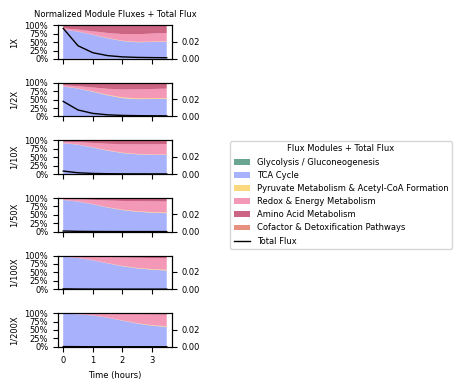

In [113]:
time_points = np.arange(0, 4*60*60+1, 30*60)  # 30 min intervals for 4 hours

fig, axes = plt.subplots(len(d_factors), 1, figsize=(2.2, 4), sharex=True)

def format_dilution_label(d):
    if d == 1:
        return "1X"
    elif d == 0.5:
        return "1/2X"
    elif d == 0.1:
        return "1/10X"
    elif d == 0.02:
        return "1/50X"
    elif d == 0.01:
        return "1/100X"
    elif d == 0.005:
        return "1/200X"

all_total_fluxes = []  # For global y-axis scaling
line_axes = []         # Store second y-axes

for i, d in enumerate(d_factors):
    ax = axes[i]

    module_fluxes = {module: [] for module in pathway_dict}
    total_flux_over_time = []

    rfit.model.setGlobalParameterValues(
        [*list(param_labels_dict.values()), 1, 98, 100, 102, 104], 
        [*list(param_values_dict.values()), d, 0, 0, 0, 0]
    )
    rfit.reset()

    for j in range(len(time_points)-1):
        rfit.simulate(int(time_points[j]), int(time_points[j+1]))
        reaction_fluxes = np.abs(rfit.getReactionRates())
        reaction_ids = rfit.getReactionIds()

        total_flux = np.sum(reaction_fluxes)
        total_flux_over_time.append(total_flux)

        module_fluxes_step = {}
        for module, labels in pathway_dict.items():
            module_size = len(labels) if len(labels) > 0 else 1
            module_flux = sum(reaction_fluxes[reaction_ids.index(label)]
                              for label in labels if label in reaction_ids)
            module_fluxes_step[module] = module_flux / module_size

        total_at_t = sum(module_fluxes_step.values()) if total_flux > 0 else 1
        for module in module_fluxes_step:
            module_fluxes[module].append(module_fluxes_step[module] / total_at_t)

    all_total_fluxes.extend(total_flux_over_time)
    stacked_fluxes = np.vstack([module_fluxes[module] for module in module_fluxes])

    module_color_dict = {
        "Glycolysis / Gluconeogenesis": "#2A7F62",
        "TCA Cycle": "#8390FA",
        "Pyruvate Metabolism & Acetyl-CoA Formation": "#FAC748",
        "Redox & Energy Metabolism": "#F06C9B",
        "Amino Acid Metabolism": "#B6244F",
        "Cofactor & Detoxification Pathways": "#DD614A"
    }
    colors = [module_color_dict[m] for m in module_fluxes]

    if stacked_fluxes.shape[1] == len(time_points) - 1:
        ax.stackplot(time_points[:-1] / 3600, stacked_fluxes,
                     labels=module_fluxes.keys(), colors=colors, alpha=0.7)
    else:
        print(f"Shape mismatch for d={d}: {stacked_fluxes.shape} vs {len(time_points)-1}")

    ax.set_ylabel(format_dilution_label(d), fontsize=6)

    # Set left y-axis as percentage
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(["0%", "25%", "50%", "75%", "100%"], fontsize=6)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

    # Twin axis for total flux line
    ax2 = ax.twinx()
    line_total_flux, = ax2.plot(time_points[:-1] / 3600, total_flux_over_time, color='black', lw=1, label="Total Flux")
    line_axes.append(ax2)
    ax2.tick_params(axis='y', labelsize=6)

    if i == 0:
        ax.set_title("Normalized Module Fluxes + Total Flux", fontsize=6)

    if i == len(d_factors) - 1:
        ax.set_xlabel("Time (hours)", fontsize=6)
        ax2.set_xlabel("Time (hours)", fontsize=6)

    rfit.resetToOrigin()

# Set consistent total flux y-limits
max_total_flux = max(all_total_fluxes)
for ax2 in line_axes:
    ax2.set_ylim(0, max_total_flux * 1.1)

# Shared legend outside plot
handles_area, labels_area = axes[0].get_legend_handles_labels()
handles = handles_area + [line_total_flux]
labels = labels_area + ["Total Flux"]
fig.legend(handles, labels, title="Flux Modules + Total Flux",
           bbox_to_anchor=(1.05, 0.5), loc="center left", fontsize=6, title_fontsize=6)

plt.tight_layout()
plt.savefig("/workspaces/ECFERS/notebooks/endogenous_analysis/Figure_4A.pdf")
plt.show()

## Figure 4B:
### Zoom in to each of these biosynthetic modules (1 subplot each). What does the total reaction flux (y axis) look like across dilution factors (x axis)? What is the dilution factor which achieves half-max (vertical line)?

In [34]:
d_factors = [1/200, 1/100, 1/50, 1/10, 1/4, 1/2, 3/4, 1]

In [38]:
def simulate_and_record_rates(rfit, d):
    print(d)
    totaltime = 60
    addedtime = 60*5
    
    rfit.model.setGlobalParameterValues(
        [*list(param_labels_dict.values()), 1, 98, 100, 102, 104], 
        [*list(param_values_dict.values()), d, 0, 0, 0, 0]
    )
    rfit.reset()

    rfit.simulate(0, totaltime)
    ratesarray = np.atleast_2d(rfit.getReactionRates()).T  # Make it a column vector (n_reactions, 1)

    while totaltime <= 1*60*60:
        rfit.model.setGlobalParameterValues(
            [*list(param_labels_dict.values()), 1, 98, 100, 102, 104], 
            [*list(param_values_dict.values()), d, 0, 0, 0, 0]
        )
        rfit.reset()
        rfit.simulate(0, totaltime + addedtime)
        rates = np.atleast_2d(rfit.getReactionRates()).T  # Convert to column vector

        ratesarray = np.concatenate((ratesarray, rates), axis=1)  # Append as new column
        totaltime += addedtime

        print(totaltime)

        rfit.resetToOrigin()
    
    rfit.resetToOrigin()

    return ratesarray

In [39]:
def calc_reaction_metrics(ratesarray):
    addedtime = 60
    # Assume ratesarray has shape (n_reactions, n_timepoints)
    timepoints = np.arange(ratesarray.shape[1]) * addedtime  # Generate time values

    # 1) Find the time point at which the max magnitude rate occurs
    max_indices = np.argmax(np.abs(ratesarray), axis=1)  # Indices of max abs value
    max_times = timepoints[max_indices]  # Convert indices to time values

    # 2) Find the max magnitude rate value
    max_rates = np.max(np.abs(ratesarray), axis=1)

    # 3) Compute the average rate for each reaction
    average_rates = np.mean(ratesarray, axis=1)

    # 4) Compute the total magnitude of flux (integral of absolute rates over time)
    total_flux = np.sum(np.abs(ratesarray), axis=1) * addedtime  # Trapezoidal approx.

    return max_times, max_rates, average_rates, total_flux

In [40]:
dil_max_times = []
dil_max_rates = []
dil_avg_rates = []
dil_tot_flux = []

# Simulate the endogenous lysate at each of the dilution factors
for dil_fact in d_factors:
    rates_array = simulate_and_record_rates(rfit, dil_fact)
    appenders = calc_reaction_metrics(rates_array)
    mylists = [dil_max_times, dil_max_rates, dil_avg_rates, dil_tot_flux]
    for x, lst in zip(appenders, mylists):
        lst.append(x)

0.005
360
660
960
1260
1560
1860
2160
2460
2760
3060
3360
3660
0.01
360
660
960
1260
1560
1860
2160
2460
2760
3060
3360
3660
0.02
360
660
960
1260
1560
1860
2160
2460
2760
3060
3360
3660
0.1
360
660
960
1260
1560
1860
2160
2460
2760
3060
3360
3660
0.25
360
660
960
1260
1560
1860
2160
2460
2760
3060
3360
3660
0.5
360
660
960
1260
1560
1860
2160
2460
2760
3060
3360
3660
0.75
360
660
960
1260
1560
1860
2160
2460
2760
3060
3360
3660
1
360
660
960
1260
1560
1860
2160
2460
2760
3060
3360
3660


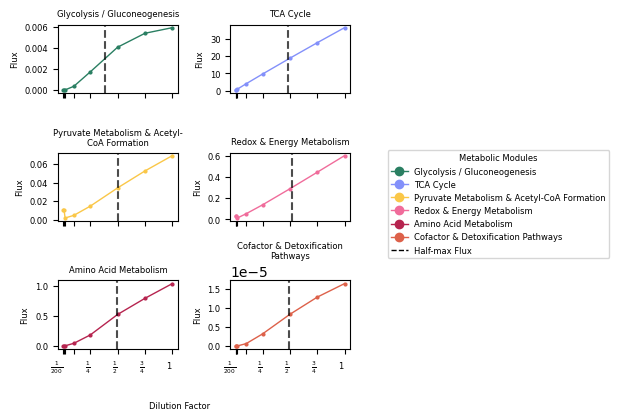

In [41]:
# Define dilution factors and their labels
d_factors = np.array([1/200, 1/100, 1/50, 1/10, 1/4, 1/2, 3/4, 1])
d_labels = [r"$\frac{1}{200}$", r"$\frac{1}{100}$",
            r"$\frac{1}{50}$", r"$\frac{1}{10}$", r"$\frac{1}{4}$",
            r"$\frac{1}{2}$", r"$\frac{3}{4}$", r"$1$"]

# Use the same module colors from the stacked area plot
num_modules = len(module_fluxes)
module_color_dict = {
    "Glycolysis / Gluconeogenesis": "#2A7F62",
    "TCA Cycle": "#8390FA",
    "Pyruvate Metabolism & Acetyl-CoA Formation": "#FAC748",
    "Redox & Energy Metabolism": "#F06C9B",
    "Amino Acid Metabolism": "#B6244F",
    "Cofactor & Detoxification Pathways": "#DD614A"
}
colors = [module_color_dict[m] for m in module_fluxes]

# Create subplots in a 3-row × 2-column layout
ncols = 2
nrows = int(np.ceil(num_modules / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.7, 4.2), sharex=True)

axes = axes.flatten()

for idx, (ax, (module, color)) in enumerate(zip(axes, zip(module_fluxes.keys(), colors))):
    module_flux = []

    for i in range(len(d_factors)):
        total_flux = sum(dil_tot_flux[i][reaction_ids.index(reaction)]
                         for reaction in pathway_dict[module] if reaction in reaction_ids)
        module_flux.append(total_flux)

    module_flux = np.array(module_flux)

    max_flux = np.max(module_flux)
    half_max_flux = max_flux / 2
    above_half_max = np.where(module_flux >= half_max_flux)[0]

    if len(above_half_max) > 0 and above_half_max[0] > 0:
        idx1, idx2 = above_half_max[0] - 1, above_half_max[0]
        d1, d2 = d_factors[idx1], d_factors[idx2]
        f1, f2 = module_flux[idx1], module_flux[idx2]
        half_max_dilution = np.interp(half_max_flux, [f1, f2], [d1, d2])
    else:
        half_max_dilution = d_factors[0]

    ax.plot(d_factors, module_flux, linestyle='-', color=color, marker='o', markersize=2, label=module, linewidth=1)
    ax.axvline(x=half_max_dilution, linestyle='--', color='black', alpha=0.7)

    wrapped_title = "\n".join(textwrap.wrap(module, width=30))  # Adjust width as needed
    ax.set_title(wrapped_title, fontsize=6, wrap=True)

    ax.set_ylabel("Flux", fontsize=6)
    ax.tick_params(labelsize=6)
    # Define which labels to show (None means skip that label but keep the tick)
    filtered_labels = [r"$\frac{1}{200}$", None,
            None, None, r"$\frac{1}{4}$",
            r"$\frac{1}{2}$", r"$\frac{3}{4}$", r"$1$"]

    ax.set_xticks(d_factors)
    ax.set_xticklabels(filtered_labels, rotation=0, ha='right', fontsize=6)

    ax.yaxis.set_tick_params(labelsize=6)

# Turn off unused axes
for i in range(num_modules, len(axes)):
    fig.delaxes(axes[i])

# Custom legend
module_handles = [plt.Line2D([0], [0], color=color, linestyle='-', marker='o', linewidth=1)
                  for color in colors]
half_max_handle = plt.Line2D([0], [0], color='black', linestyle='--', linewidth=1, label="Half-max Flux")

fig.legend(module_handles + [half_max_handle],
           list(module_fluxes.keys()) + ["Half-max Flux"],
           title="Metabolic Modules",
           bbox_to_anchor=(1.05, 0.5), loc="center left",
           fontsize=6, title_fontsize=6)

fig.supxlabel("Dilution Factor", fontsize=6)

plt.tight_layout()
plt.savefig("/workspaces/ECFERS/notebooks/endogenous_analysis/Figure_4B.pdf")
plt.show()

## Figure 4C:
### Heatmap: How do reactions/metabolites(?) change relative to dilution or an inhibitor (first introduction)? x-axis is either a reaction or a metabolite; y-axis is a dilution factor or +/- HCT (or a combination?); hue of heatmap corresponds to either total reaction flux or total metabolite production/consumption.

In [43]:
species_list = []
for s in rfit.getInitialAssignmentIds():
    if s.startswith('C'):
        species_list.append(s)

In [44]:
# Interventions: dilution factors and HCT condition
d_factors = [1, 1/2, 1/10, 1/50, 1/100, 1/200]
intervention_labels = ["1X + HCT"] + [f"1/{int(1/d)}X" if d != 1 else "1X" for d in d_factors]
# intervention_labels = ['HCT=1'] + [f'dil={d}' for d in d_factors]

In [45]:
metabolite_ids = np.array(species_list)

In [46]:
def signed_log(x, clip=1e-3):
    return np.sign(x) * np.log10(np.clip(np.abs(x), clip, None))

/tmp/ipykernel_57746/2974602892.py:31: RuntimeWarning:

invalid value encountered in divide



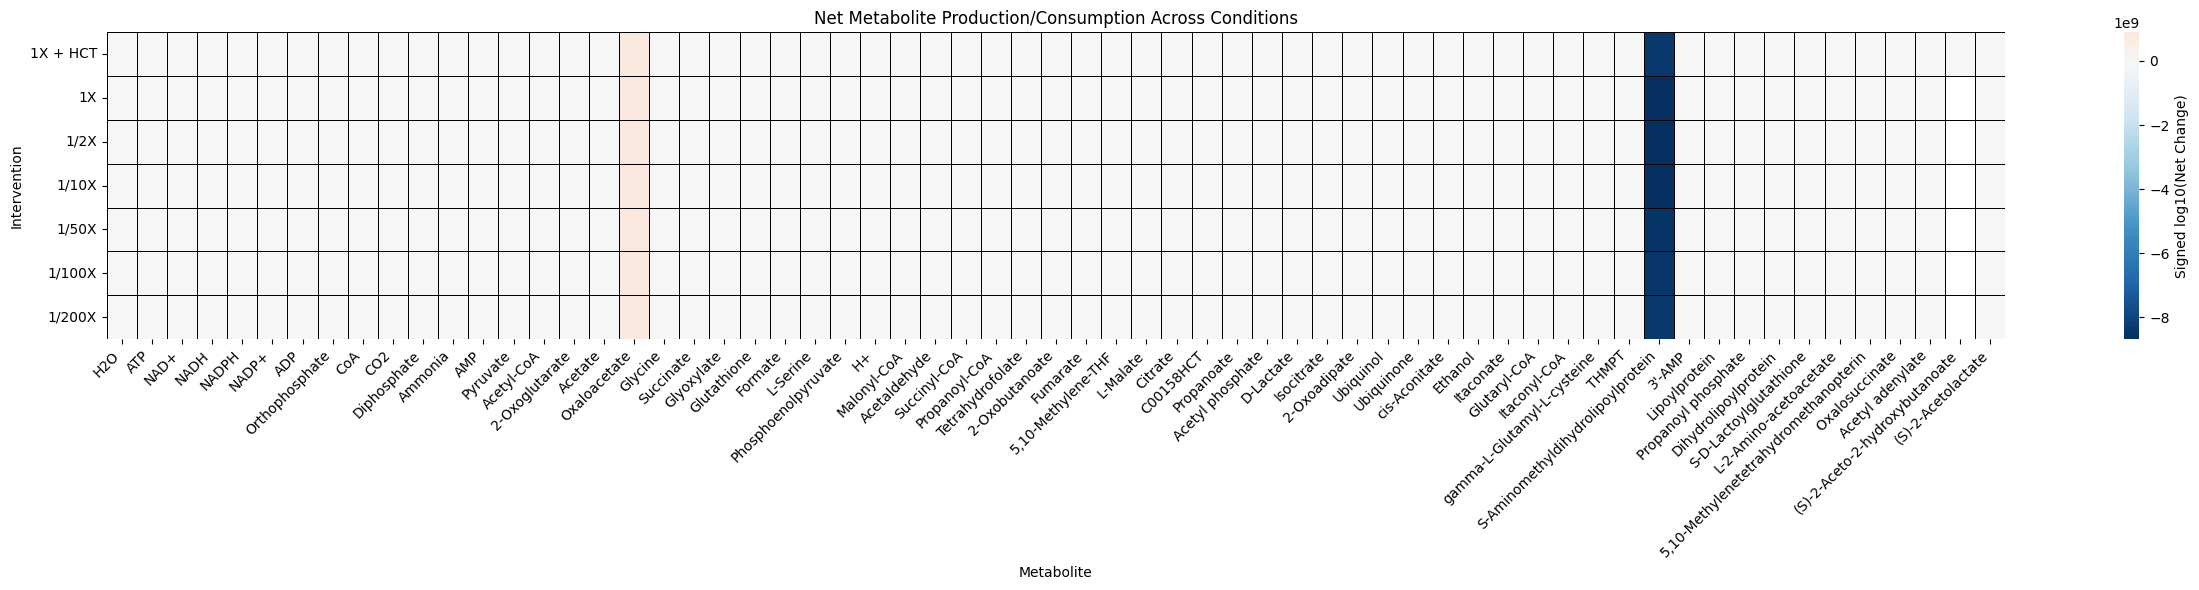

In [53]:
# Storage for results
heatmap_data = []

# ---- Run simulation for HCT condition ----
hct = 10
v672 = hct / (1e-5 * (1))
param_values_dict['v672'] = v672

rfit.model.setGlobalParameterValues(
    [*list(param_labels_dict.values()), 1, 98, 100, 102, 104], 
    [*list(param_values_dict.values()), d, 0, 0, 0, 0]
)
rfit.reset()

simresults = rfit.simulate(0,60*4*60)
net_metabolite_change = (simresults[-1][1:64] - simresults[0][1:64])/simresults[0][1:64]

heatmap_data.append(net_metabolite_change)

# ---- Loop through dilution factors ----
for d in d_factors:
    # Set dilution in parameter dict
    param_values_dict['v672'] = 0  # no HCT
    rfit.model.setGlobalParameterValues(
        [*list(param_labels_dict.values()), 1, 98, 100, 102, 104], 
        [*list(param_values_dict.values()), d, 0, 0, 0, 0]
    )
    rfit.reset()

    simresults = rfit.simulate(0,60*4*60)
    net_metabolite_change = (simresults[-1][1:64] - simresults[0][1:64])/simresults[0][1:64]

    heatmap_data.append(net_metabolite_change)

# ---- Build DataFrame and apply log transform ----
translated_ids = []
for id in metabolite_ids:
    try:
        translated_ids.append(translator_dict[id])
    except KeyError:
        translated_ids.append(id)

heatmap_df = pd.DataFrame(heatmap_data, columns=translated_ids, index=intervention_labels)

# ---- Plot ----                                      
plt.figure(figsize=(25, 6))
sns.heatmap(
    heatmap_df,
    cmap="RdBu_r",
    center=0,     # makes white = 0 (no change)
    xticklabels=True,
    yticklabels=True,
    linecolor='black',     # color of the grid lines
    linewidths=0.5,        # thickness of the lines
    cbar_kws={"label": "Signed log10(Net Change)"}
)
plt.xlabel("Metabolite")
plt.ylabel("Intervention")
plt.title("Net Metabolite Production/Consumption Across Conditions")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Now we may want to look at reaction flux rather than individual metabolites production/consumption

In [ ]:
d_factors = [1, 1/10, 1/200]

# Interventions: dilution factors and HCT condition
intervention_labels = ["1X + HCT"] + [f"1/{int(1/d)}X" if d != 1 else "1X" for d in d_factors]

In [305]:
# Simulation setup
total_time = 4 * 60 * 60  # 8 hours
dt = 60*20
num_steps = total_time // dt
stoich_matrix = rfit.getFullStoichiometryMatrix()

In [306]:
rids = []
for rxn in rfit.getReactionIds():
    if rxn.startswith('R'):
        rids.append(rxn)

In [307]:
reaction_labels = []

for r in rids:
    row = model_rxns[model_rxns['Label'] == r]
    keggid = row['Reaction ID'].values[0]

    reaction_labels.append(keggid)

In [308]:
ordered_labels = {}

for pathway, rids_in_pathway in pathway_dict.items():
    labels_list = []
    for rid in rids_in_pathway:
        if rid in rids:
            idx = rids.index(rid)
            labels_list.append(reaction_labels[idx])
    ordered_labels[pathway] = labels_list

In [330]:
# Storage for results
heatmap_data = []
intervention_labels = []

hct = 1000
time_points = np.arange(0, 4*60*60 + 1, 20*60)  # 10 min intervals for 8 hours
dt = 30 * 60  # 30 minutes in seconds

for d in d_factors:
    for hct_state, v672_value in [('-HCT', 0), ('+HCT', hct / (1e-5 * d))]:
        # Copy param_values_dict to avoid modifying it globally
        param_values = param_values_dict.copy()
        param_values['v672'] = v672_value

        # Set parameters in the model
        rfit.model.setGlobalParameterValues(
            [*list(param_labels_dict.values()), 1, 98, 100, 102, 104],
            [*list(param_values.values()), d, 0, 0, 0, 0]
        )
        rfit.reset()

        # Simulate and collect rates
        rate_records = []
        for j in range(len(time_points) - 1):
            rfit.simulate(int(time_points[j]), int(time_points[j + 1]))
            rate_records.append(rfit.getReactionRates()[:57])

        rate_records = np.array(rate_records)
        integrated_flux = np.trapz(rate_records, dx=dt, axis=0)

        # Store results
        heatmap_data.append(integrated_flux)
        intervention_labels.append(f"{d}X ({hct_state})")

        rfit.resetToOrigin()

# Build DataFrame
heatmap_df = pd.DataFrame(heatmap_data, columns=rids, index=intervention_labels)

In [332]:
def symmetric_log_transform(x, lin_thresh=1e-2):
    """
    Apply a symmetric log transform that:
    - Acts linearly near 0 (for values smaller than lin_thresh),
    - Applies log scaling beyond that.
    """
    x = np.asarray(x)
    sign = np.sign(x)
    abs_x = np.abs(x)

    linear_region = abs_x < lin_thresh
    transformed = np.empty_like(x, dtype=float)

    # Linear region: keep the values as-is
    transformed[linear_region] = abs_x[linear_region] / lin_thresh

    # Log region: scale log10 starting from lin_thresh
    transformed[~linear_region] = 1 + np.log10(abs_x[~linear_region] / lin_thresh)

    return sign * transformed

In [333]:
heatmap_log_signed = heatmap_df.applymap(symmetric_log_transform)

/tmp/ipykernel_57746/3950875419.py:1: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [334]:
# Use rids instead of reaction_labels to preserve uniqueness
flattened_rids = []
module_boundaries = []
for pathway, rids_in_pathway in pathway_dict.items():
    filtered = [rid for rid in rids_in_pathway if rid in rids]
    flattened_rids.extend(filtered)
    module_boundaries.append(len(flattened_rids))  # 1-based index

heatmap_reordered = heatmap_log_signed[flattened_rids]

In [335]:
# Map from rid to full reaction label
rid_to_label = dict(zip(rids, reaction_labels))
xtick_labels = [rid_to_label[rid] for rid in flattened_rids]

/tmp/ipykernel_57746/3743822811.py:29: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



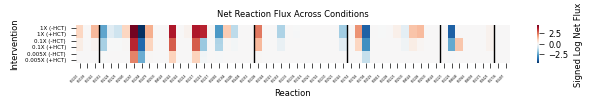

In [336]:
plt.figure(figsize=(7, 0.5))
ax = sns.heatmap(
    heatmap_reordered,
    cmap="RdBu_r",
    xticklabels=xtick_labels,
    yticklabels=True,
    center=0,
    cbar_kws={"label": "Signed Log Net Flux"}
)

# Add vertical lines between modules
for boundary in module_boundaries[:-1]:
    ax.axvline(boundary, color='black', linewidth=1)

# Tick and label formatting
ax.tick_params(axis='x', width=0.5)
ax.tick_params(axis='y', width=0.5)
ax.set_ylabel("Intervention", fontsize=6)
ax.set_xlabel("Reaction", fontsize=6)
ax.set_title("Net Reaction Flux Across Conditions", fontsize=6)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=2)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=4)

# Format colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6, width=0.5)
cbar.set_label("Signed Log Net Flux", fontsize=6)

plt.tight_layout()
plt.savefig("/workspaces/ECFERS/notebooks/endogenous_analysis/Figure_4C.pdf")
plt.show()

And what if we look at the actual magnitude of differences in samples with and without HCT and with/without dilution

In [337]:
hct_difference = (heatmap_df.iloc[1] - heatmap_df.iloc[0]) # WITH HCT - withOUT HCT

In [338]:
# Use rids instead of reaction_labels to preserve uniqueness
flattened_rids = []
module_boundaries = []
for pathway, rids_in_pathway in pathway_dict.items():
    filtered = [rid for rid in rids_in_pathway if rid in rids]
    flattened_rids.extend(filtered)
    module_boundaries.append(len(flattened_rids))  # 1-based index

hct_difference_reordered = hct_difference[flattened_rids]

/tmp/ipykernel_57746/326321623.py:20: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



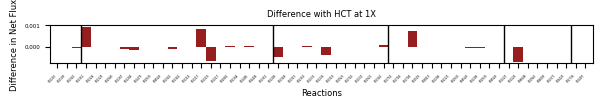

In [339]:
x_labels = [rid_to_label[rid] for rid in hct_difference_reordered.index]

plt.figure(figsize=(7, 0.5))
ax = hct_difference_reordered.plot(kind='bar', color='#961E1EFF', width=1.0)

# Set custom x-tick labels using full reaction labels
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=2)

# Set labels and title
ax.set_xlabel('Reactions', fontsize=6)
ax.set_ylabel('Difference in Net Flux', fontsize=6)
ax.set_title("Difference with HCT at 1X", fontsize=6)
ax.tick_params(axis='y', labelrotation=0, labelsize=4)

# Add vertical lines between modules
for boundary in module_boundaries[:-1]:
    ax.axvline(boundary - 0.5, color='black', linewidth=1)  # -0.5 for alignment between bars

plt.tight_layout()
plt.show()

Differences in net flux with respect to dilution

In [340]:
dil_difference = heatmap_df.iloc[4] - heatmap_df.iloc[0] # 200X - 1X

In [341]:
# Use rids instead of reaction_labels to preserve uniqueness
flattened_rids = []
module_boundaries = []
for pathway, rids_in_pathway in pathway_dict.items():
    filtered = [rid for rid in rids_in_pathway if rid in rids]
    flattened_rids.extend(filtered)
    module_boundaries.append(len(flattened_rids))  # 1-based index

dil_difference_reordered = dil_difference[flattened_rids]

/tmp/ipykernel_57746/861405300.py:20: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



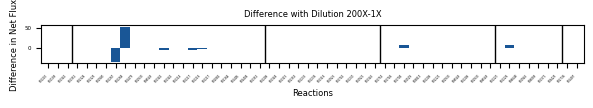

In [342]:
x_labels = [rid_to_label[rid] for rid in dil_difference_reordered.index]

plt.figure(figsize=(7, 0.5))
ax = dil_difference_reordered.plot(kind='bar', color='#195696', width=1.0)

# Set custom x-tick labels using full reaction labels
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=2)

# Set labels and title
ax.set_xlabel('Reactions', fontsize=6)
ax.set_ylabel('Difference in Net Flux', fontsize=6)
ax.set_title("Difference with Dilution 200X-1X", fontsize=6)
ax.tick_params(axis='y', labelrotation=0, labelsize=4)

# Add vertical lines between modules
for boundary in module_boundaries[:-1]:
    ax.axvline(boundary - 0.5, color='black', linewidth=1)  # -0.5 for alignment between bars

plt.tight_layout()
plt.show()

Formatting - putting them together

In [348]:
# Filter columns where all values are below a magnitude of 0.1
col_mask = heatmap_reordered.abs().max(axis=0) >= 0.001 # not more than a micromolar difference? cut it
heatmap_reordered_filtered = heatmap_reordered.loc[:, col_mask]
hct_difference_filtered = hct_difference_reordered[col_mask]
dil_difference_filtered = dil_difference_reordered[col_mask]

# Update label mapping
filtered_columns = heatmap_reordered_filtered.columns
x_labels = [rid_to_label[rid] for rid in filtered_columns]

# Prepare data
abs_hct_diff = hct_difference_filtered[filtered_columns].abs()
abs_dil_diff = dil_difference_filtered[filtered_columns].abs()

x = np.arange(len(filtered_columns))
bar_width = 0.5

In [ ]:
# Map each internal reaction ID to its module
rid_to_module = {}
for module, rids in pathway_dict.items():
    for rid in rids:
        rid_to_module[rid] = module

In [359]:
# Get module names for filtered columns
filtered_modules = [rid_to_module.get(rid, 'Unknown') for rid in filtered_columns]

# Compute new module boundaries
module_boundaries = [0]
for i in range(1, len(filtered_modules)):
    if filtered_modules[i] != filtered_modules[i - 1]:
        module_boundaries.append(i)
module_boundaries.append(len(filtered_modules))

In [361]:
# Calculate center position for each module block
module_labels = []
module_positions = []

for i in range(len(module_boundaries) - 1):
    start = module_boundaries[i]
    end = module_boundaries[i + 1]
    mid = (start + end) / 2
    module_positions.append(mid)
    module_labels.append(filtered_modules[start])

/tmp/ipykernel_57746/3691659547.py:58: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



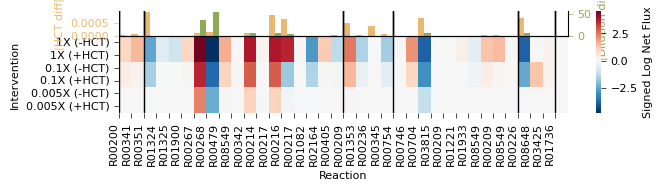

In [367]:
# Set up figure and axes
fig, ax_heatmap = plt.subplots(figsize=(7, 2))
divider = make_axes_locatable(ax_heatmap)
ax_bar_left = divider.append_axes("top", size=0.25, pad=0.00, sharex=ax_heatmap)  # Reduced height
ax_bar_right = ax_bar_left.twinx()

# Plot left bars (HCT) aligned to centers
ax_bar_left.bar(x + bar_width / 2, abs_hct_diff.values, width=bar_width, color='#E9B872', label='|HCT diff|')

# Plot right bars (Dilution)
ax_bar_right.bar(x + bar_width + bar_width / 2, abs_dil_diff.values, width=bar_width, color='#90A959', label='|Dilution diff|')

# Format top bar plots
ax_bar_left.set_ylabel('|HCT diff|', fontsize=8, color='#E9B872')
ax_bar_left.tick_params(axis='y', labelsize=8, width=0.5, colors='#E9B872')
ax_bar_left.tick_params(axis='x', bottom=False, labelbottom=False)
ax_bar_left.spines[['top', 'right', 'left']].set_visible(False)

ax_bar_right.set_ylabel('|Dilution diff|', fontsize=8, color='#90A959')
ax_bar_right.tick_params(axis='y', labelsize=8, width=0.5, colors='#90A959')
ax_bar_right.spines[['top', 'left']].set_visible(False)

# Heatmap
sns.heatmap(
    heatmap_reordered_filtered,
    cmap="RdBu_r",
    xticklabels=True,
    yticklabels=True,
    center=0,
    cbar_kws={"label": "Signed Log Net Flux"},
    ax=ax_heatmap
)

# Apply correct x tick labels
ax_heatmap.set_xticks(x)
ax_heatmap.set_xticklabels(x_labels, rotation=90, ha='right', fontsize=8)

# Module boundary lines (recalculate if needed based on filtered columns)
for boundary in module_boundaries[:-1]:
    if boundary < len(filtered_columns):
        ax_heatmap.axvline(boundary, color='black', linewidth=1)
        ax_bar_left.axvline(boundary, color='black', linewidth=1)
        ax_bar_right.axvline(boundary, color='black', linewidth=1)

# Heatmap axis formatting
ax_heatmap.tick_params(axis='x', width=0.5)
ax_heatmap.tick_params(axis='y', width=0.5)
ax_heatmap.set_xlabel("Reaction", fontsize=8)
ax_heatmap.set_ylabel("Intervention", fontsize=8)
ax_heatmap.set_title("Net Reaction Flux Across Conditions", fontsize=8)
ax_heatmap.set_yticklabels(ax_heatmap.get_yticklabels(), fontsize=8)

# Colorbar formatting
cbar = ax_heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=8, width=0.5)
cbar.set_label("Signed Log Net Flux", fontsize=8)

plt.tight_layout()
plt.savefig("/workspaces/ECFERS/notebooks/endogenous_analysis/Figure_4C_combo_dualyaxis.pdf")
plt.show()

## Figure 4D:
### Looking towards the sinks of the system

In [242]:
# Set parameters in the model
rfit.model.setGlobalParameterValues(
    [*list(param_labels_dict.values()), 1, 98, 100, 102, 104],
    [*list(param_values.values()), d, 0, 0, 0, 0]
)
rfit.reset()

simresults = rfit.simulate(0,60*4*60)
net_metabolite_diff = (simresults[-1][1:64] - simresults[0][1:64])
net_metabolite_change = (simresults[-1][1:64] - simresults[0][1:64])/simresults[0][1:64]

In [243]:
species_list = []
for s in rfit.getInitialAssignmentIds():
    if s.startswith('C'):
        species_list.append(s)

In [244]:
metabolite_ids = np.array(species_list)

In [245]:
translated_ids = []
for id in metabolite_ids:
    try:
        translated_ids.append(translator_dict[id])
    except KeyError:
        translated_ids.append(id)

/tmp/ipykernel_57746/20927061.py:36: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipykernel_57746/20927061.py:41: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipykernel_57746/20927061.py:43: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



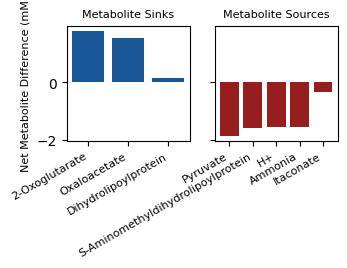

In [271]:
# Convert to numpy arrays
translated_ids = np.array(translated_ids)
net_metabolite_diff = np.array(net_metabolite_diff)

# Filter out small values
mask = np.abs(net_metabolite_diff) >= 0.1
filtered_ids = translated_ids[mask]
filtered_diffs = net_metabolite_diff[mask]

# Separate positives (sinks) and negatives (sources)
pos_mask = filtered_diffs > 0
neg_mask = filtered_diffs < 0

pos_ids = filtered_ids[pos_mask]
pos_diffs = filtered_diffs[pos_mask]
neg_ids = filtered_ids[neg_mask]
neg_diffs = filtered_diffs[neg_mask]

# Sort by absolute magnitude
pos_sorted_idx = np.argsort(np.abs(pos_diffs))[::-1]
neg_sorted_idx = np.argsort(np.abs(neg_diffs))[::-1]

pos_ids_sorted = pos_ids[pos_sorted_idx]
pos_diffs_sorted = pos_diffs[pos_sorted_idx]

neg_ids_sorted = neg_ids[neg_sorted_idx]
neg_diffs_sorted = neg_diffs[neg_sorted_idx]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.5, 1.5), sharey=True)

# Metabolite Sinks (positive)
ax1.bar(pos_ids_sorted, pos_diffs_sorted, color='#195696')
ax1.set_title("Metabolite Sinks", fontsize=8)
ax1.set_ylabel("Net Metabolite Difference (mM)", fontsize=8)
ax1.set_xticklabels(pos_ids_sorted, rotation=30, ha='right', fontsize=8)

# Metabolite Sources (negative)
ax2.bar(neg_ids_sorted, neg_diffs_sorted, color='#961E1EFF')
ax2.set_title("Metabolite Sources", fontsize=8)
ax2.set_xticklabels(neg_ids_sorted, rotation=30, ha='right', fontsize=8)

plt.tight_layout()
plt.savefig("/workspaces/ECFERS/notebooks/endogenous_analysis/Figure_4D.pdf")
plt.show()

## Figure 4E:
### SBMLNetwork maps of base and altered system: how does the addition of HCT change the map? Looking at reaction flux or metabolite concentrations here